**Objectives**

1) Using Reddit's API, you'll collect posts from two subreddits of your choosing.

2) You'll then use NLP to train a classifier on which subreddit a given post came from. This is a binary classification problem.

Sub-reddits chosen:
- r/worldnews: World News
- r/todayilearned: Today I Learned (TIL)


Overview:

1) Gather and prepare data from 2 subreddits using the requests library 

- 1.1 Get the relevant URL (i.e. the relevant sub-reddit urls)
- 1.2 Make a request API call (ensure that the status code is 200; if rejected, change header)
- 1.3 Convert it into a relevant format (either .json or .text) - in this case we should start with .json
- 1.4 Unpack the .json (dictionary) to get the relevant data (i.e. the subreddit posts)
- 1.5 Compile the relevant data (sub-reddit posts) into a dataframe 

Repeat steps 1.1 to 1.5 using a for loop with sleep function to scrape <= 1000 comments from each of the 2 sub-reddit forums 

We are going to be scraping 100 comments per sleep cycle / for loop call, so we are going to run the scraping function 10 times. 

2) Clean up the dataframe

- 2.1 Posts from the 2 sub-reddit forums 
- using beautiful soup / regex 
- lowercase, strip non-alphabets, strip stop words, (note that the countvectorizer automatically performs these 3 steps for us already)
- stemming/lemmatize (countvectorizer does not do this for us so we have to perform this separately) 


- 2.2 Target variable (classifier)
- create dummy variables (1 or 0 for either sub-reddit forum)


3) Use the cleaned up comments to train 2 classification models using:

- 3.1 Bayes Classifier (use this score as a base model for comparison - it fits quickly and does quite well as a naive model) 
- rmb: the naive bayes model that you choose should be decided based on the predictor features, and not the target variables (e.g. if you use TFID, your output is going to be continuous, so you should use the Gaussian Bayes model, if it is multi class, then multiclass, if dummy then bernoulli) 


- 3.2 Logistic Regression / Knn / any other model 


4) Conclusions 

 * rmb to include an executive summary in a readme file 

 * To consider: 
 - how time impacts the relevant of the posts that you use to fit your classification model (more recent posts should be assigned heavier weights as the words used are presumably more relevant?) > how to account for this in your model?

- Using the pipeline function / Gridsearch to select the optimal model / parameters / hyper-parameters 


**Loading Libraries**

In [3]:
#libraries for scraping and organizing data
import requests
import pandas as pd
import time
import random

#libraries for cleaning comments post scraping
from bs4 import BeautifulSoup
import regex as re
from nltk.corpus import stopwords 


# Data Collection 

**Scraping for comments from 2 subreddit forums**

Testing out the scraping step by step first before using a for loop scraping function. Testing on the 'world news' sub-reddit first

In [3]:
#rmb that we need to add the .json behind 
url = 'https://www.reddit.com/r/worldnews/.json'

In [4]:
res = requests.get(url)

Ensuring that the API call was a success

In [5]:
res.status_code #success!

200

Converting the response file into json 

In [6]:
reddit_dict = res.json()

Time to do some data exploration 

In [8]:
len(reddit_dict)

2

Lets explore the available keys 

In [10]:
reddit_dict.keys()

dict_keys(['kind', 'data'])

In [12]:
reddit_dict['kind'] #there is nothing much here 

'Listing'

In [13]:
reddit_dict['data'] #everything is in the data key 

{'modhash': '',
 'dist': 25,
 'children': [{'kind': 't3',
   'data': {'approved_at_utc': None,
    'subreddit': 'worldnews',
    'selftext': '',
    'author_fullname': 't2_2yqt',
    'saved': False,
    'mod_reason_title': None,
    'gilded': 0,
    'clicked': False,
    'title': "Boris Johnson said UK's poorest communities are made-up of 'chavs,' 'burglars,' 'drug addicts,' and 'losers'",
    'link_flair_richtext': [],
    'subreddit_name_prefixed': 'r/worldnews',
    'hidden': False,
    'pwls': 6,
    'link_flair_css_class': None,
    'downs': 0,
    'hide_score': False,
    'name': 't3_e484sc',
    'quarantine': False,
    'link_flair_text_color': 'dark',
    'author_flair_background_color': None,
    'subreddit_type': 'public',
    'ups': 3669,
    'total_awards_received': 0,
    'media_embed': {},
    'author_flair_template_id': None,
    'is_original_content': False,
    'user_reports': [],
    'secure_media': None,
    'is_reddit_media_domain': False,
    'is_meta': False,
    

Drilling down even further - exploring the different key values within data. Looks like the main stuff is to be found in the 'children' key 

In [14]:
reddit_dict['data'].keys()

dict_keys(['modhash', 'dist', 'children', 'after', 'before'])

In [15]:
reddit_dict['data']['modhash']

''

In [16]:
reddit_dict['data']['dist']

25

In [17]:
reddit_dict['data']['children']

[{'kind': 't3',
  'data': {'approved_at_utc': None,
   'subreddit': 'worldnews',
   'selftext': '',
   'author_fullname': 't2_2yqt',
   'saved': False,
   'mod_reason_title': None,
   'gilded': 0,
   'clicked': False,
   'title': "Boris Johnson said UK's poorest communities are made-up of 'chavs,' 'burglars,' 'drug addicts,' and 'losers'",
   'link_flair_richtext': [],
   'subreddit_name_prefixed': 'r/worldnews',
   'hidden': False,
   'pwls': 6,
   'link_flair_css_class': None,
   'downs': 0,
   'hide_score': False,
   'name': 't3_e484sc',
   'quarantine': False,
   'link_flair_text_color': 'dark',
   'author_flair_background_color': None,
   'subreddit_type': 'public',
   'ups': 3669,
   'total_awards_received': 0,
   'media_embed': {},
   'author_flair_template_id': None,
   'is_original_content': False,
   'user_reports': [],
   'secure_media': None,
   'is_reddit_media_domain': False,
   'is_meta': False,
   'category': None,
   'secure_media_embed': {},
   'link_flair_text': None

In [18]:
reddit_dict['data']['after']

't3_e3rg7j'

In [20]:
reddit_dict['data']['before']

Drilling down further on the [data][children] key values 

In [21]:
len(reddit_dict['data']['children'])

25

In [23]:
len(reddit_dict['data']['children'][0])

2

seems like it is a list of dictionaries - lets drill down further into each dictionary within this list of dictionaries using the first dictionary as an example

In [26]:
reddit_dict['data']['children'][0].keys()

dict_keys(['kind', 'data'])

In [27]:
reddit_dict['data']['children'][0]['kind']
#ok nothing much here

't3'

In [29]:
#most of the data resides under the data key value, which is a dictionary with 98 keys 
len(reddit_dict['data']['children'][0]['data'])

98

Taking a look at what these keys are - there are 98 of them so proabbly not very wise to access these keys one by one to find out which one contains the sub-reddit post, which is what we are looking for 

In [34]:
reddit_dict['data']['children'][0]['data'].keys()

dict_keys(['approved_at_utc', 'subreddit', 'selftext', 'author_fullname', 'saved', 'mod_reason_title', 'gilded', 'clicked', 'title', 'link_flair_richtext', 'subreddit_name_prefixed', 'hidden', 'pwls', 'link_flair_css_class', 'downs', 'hide_score', 'name', 'quarantine', 'link_flair_text_color', 'author_flair_background_color', 'subreddit_type', 'ups', 'total_awards_received', 'media_embed', 'author_flair_template_id', 'is_original_content', 'user_reports', 'secure_media', 'is_reddit_media_domain', 'is_meta', 'category', 'secure_media_embed', 'link_flair_text', 'can_mod_post', 'score', 'approved_by', 'thumbnail', 'edited', 'author_flair_css_class', 'steward_reports', 'author_flair_richtext', 'gildings', 'content_categories', 'is_self', 'mod_note', 'created', 'link_flair_type', 'wls', 'banned_by', 'author_flair_type', 'domain', 'allow_live_comments', 'selftext_html', 'likes', 'suggested_sort', 'banned_at_utc', 'view_count', 'archived', 'no_follow', 'is_crosspostable', 'pinned', 'over_18',

We want to find out which of this contains the sub-reddit posts 

In [36]:
reddit_dict['data']['children'][0]['data']['subreddit'] #ok looks like we are in the correct sub-reddit

'worldnews'

so instead of opening up the key values key by key, we will be compiling all the data from the 25 dictionaries under children into a single dataframe

In [53]:
worldnews_df = pd.DataFrame(reddit_dict['data']['children'])

In [54]:
len(worldnews_df)

25

and then unpacking the nested dictionaries within the data column to access the contents within each of the dictionary keys

In [55]:
worldnews_df = worldnews_df.data.apply(pd.Series)

looks like we found the column/key of interest - 'title' 

In [56]:
worldnews_df.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,num_comments,is_video
0,None,worldnews,,t2_2yqt,False,None,0,False,Boris Johnson said UK's poorest communities ar...,[],...,None,/r/worldnews/comments/e484sc/boris_johnson_sai...,all_ads,False,https://www.businessinsider.com/boris-johnson-...,22584828,1.575166e+09,2,526,False
1,None,worldnews,,t2_612zd,False,None,0,False,"One of Malta’s wealthiest men, Yorgen Fenech, ...",[],...,None,/r/worldnews/comments/e43j62/one_of_maltas_wea...,all_ads,False,https://www.france24.com/en/20191130-malta-pro...,22584828,1.575148e+09,2,486,False
2,None,worldnews,,t2_174cr0,False,None,1,False,"Over 1,000 climate protesters storm German coa...",[],...,None,/r/worldnews/comments/e43apr/over_1000_climate...,all_ads,False,https://www.dw.com/en/climate-protesters-storm...,22584828,1.575147e+09,5,1128,False
3,None,worldnews,,t2_zf6tr,False,None,0,False,Thousands demand Netanyahu’s resignation at Te...,[],...,None,/r/worldnews/comments/e45a9b/thousands_demand_...,all_ads,False,https://www.timesofisrael.com/thousands-demand...,22584828,1.575155e+09,0,156,False
4,None,worldnews,,t2_2nmahwux,False,None,0,False,Chinese diplomat clashes with BBC over definit...,[],...,None,/r/worldnews/comments/e41h1m/chinese_diplomat_...,all_ads,False,https://www.taiwannews.com.tw/en/news/3827703,22584828,1.575140e+09,6,978,False


Subsetting the 2 columns of interest, which is the title column containing the sub-reddit post and the sub-reddit column name

In [57]:
worldnews_df = worldnews_df[['subreddit','title']]

In [62]:
len(worldnews_df)

25

In [61]:
worldnews_df.head()

,subreddit,title
0,worldnews,Boris Johnson said UK's poorest communities ar...
1,worldnews,"One of Malta’s wealthiest men, Yorgen Fenech, ..."
2,worldnews,"Over 1,000 climate protesters storm German coa..."
3,worldnews,Thousands demand Netanyahu’s resignation at Te...
4,worldnews,Chinese diplomat clashes with BBC over definit...


In [59]:
#ok seems right! 
worldnews_df['title'][0]

"Boris Johnson said UK's poorest communities are made-up of 'chavs,' 'burglars,' 'drug addicts,' and 'losers'"

**Mini summary** 

We have accessed a sub-reddit url - the world-news one and done some digging into its contents.

We found out that the path of interest is as follows: 

- reddit_dict['data']['children'] > 25 dictionaries > ['data']['title']

This means that each API call will give us 25 subreddit posts. 

If we want to compile at <= 1000 subreddit posts we will have to run through 40 cycles. 

If we create a function that runs 4 cycles at a time, we will have to execute the function 10 times. 



**Creating the scraping for loop function**

In [ ]:
#reddit_dict['data']['children'][0]['data']['title']

testing out the dataframe concatenation process

In [71]:
p = pd.DataFrame()

In [72]:
p = pd.concat([p, worldnews_df])

In [74]:
p.head()

,subreddit,title
0,worldnews,Boris Johnson said UK's poorest communities ar...
1,worldnews,"One of Malta’s wealthiest men, Yorgen Fenech, ..."
2,worldnews,"Over 1,000 climate protesters storm German coa..."
3,worldnews,Thousands demand Netanyahu’s resignation at Te...
4,worldnews,Chinese diplomat clashes with BBC over definit...


In [75]:
p = pd.concat([p, worldnews_df])

In [76]:
p.shape #50 rows after concatenating twice so it looks like it should work fine in a function 

(50, 2)

**the function call to scrape 100 sub-reddit comments from the world-news sub-reddit forum** 

In [4]:
posts = pd.DataFrame()
after = None

for i in range(4):
    if after == None:
        params = {} 
    else:
        params ={'after' : after} 

    url = 'https://www.reddit.com/r/worldnews/.json'

    res = requests.get(url, params = params, headers={'User-agent': 'Pony Inc 1.0'}) #changing user-agent just in case

    if res.status_code == 200:
        the_json = res.json()  
        
        wn_df = pd.DataFrame(the_json['data']['children'])
        wn_df = wn_df.data.apply(pd.Series)
        wn_df = wn_df[['subreddit','title']]
        
        posts = pd.concat([posts, wn_df])
        
        after = the_json['data']['after']
        print(i)
        
    else:
        print(res.status_code)
        break 

    time.sleep(1)

0
1
2
3


In [5]:
#running it the first time looks like it executed well! we have 100 rows of posts 
posts.shape

(100, 2)

looks like the first scrape is a success

In [6]:
posts['title'][:30]

0     UK police won't pursue case against Prince And...
1     Scientist who helped develop new drug for ovar...
2     Neo-Nazi scandal hits German elite military un...
3     People in China are now required to have their...
4     Cuba found to be the most sustainably develope...
5     'War against nature must stop,' U.N. chief say...
6     Facebook rejects twice a swiss companies' ad o...
7     Hong Kong cop who drove motorbike into protest...
8     China accused UN human rights chief of “inappr...
9     Amazon warehouses are ‘cult-like’ sweatshops r...
10    Calls grow to fire University of Alberta lectu...
11    Labour leader Corbyn would stop arms sales to ...
12    Spanish Big Brother made contestant 'watch her...
13    Hong Kong protests: Police estimated tens of t...
14    World approaching ‘point of no return’ on clim...
15    Thousands took to the streets across Poland on...
16    Between Black Friday and Cyber Monday, pope co...
17    Grandmother dumps burnt remains of home at

Exporting the first run to csv first just in case 

In [7]:
posts.to_csv(r"./datasets/world_news2.csv", index=False)

Running it the second time

making some changes to the function after the first call - have to remove the dataframe instantiation if not it will wipe out all previous posts.

the after message has already been defined from the last call (i.e. call number 4 or index 3 so we should be using that after code)

In [8]:
after #this is after code from where we left off (after the first scrape)

't3_e4gsxs'

I tried defining the for loop as a function instead. It's difficult concatenating it to the first dataframe so i'm just going to create one data frame per function call? and then subsequently concatenate all the dataframes together

In [22]:
#this function is different from the first one because i will have to input 3 arguments:
#the after code (after each scrape of 100 posts)
#storing each round of 100 posts in a separate dataframe 

def wn_scrape(posts_num,after_code,num_iterate):
    
    after = after_code #this was the last 'after' code from round 1
    posts_num = pd.DataFrame()

    for i in range(num_iterate):
        if after == None:
            params = {}
        else:
            params ={'after' : after} 

        url = 'https://www.reddit.com/r/worldnews/.json'

        res = requests.get(url, params = params, headers={'User-agent': 'Pony Inc 1.0'}) #changing user-agent just in case

        if res.status_code == 200:
            the_json = res.json()  
        
            wn_df = pd.DataFrame(the_json['data']['children'])
            wn_df = wn_df.data.apply(pd.Series)
            wn_df = wn_df[['subreddit','title']]
        
            posts_num = pd.concat([posts_num, wn_df])
        
            after = the_json['data']['after']
            print(i)
        
        else:
            print(res.status_code)
            break 
            
        time.sleep(1)
        
    return posts_num, after
        

World news Scrape round 2 - next 100 posts

In [11]:
after #finding out what the last after code was 

't3_e4gsxs'

In [23]:
posts2 = wn_scrape('posts2','t3_e4gsxs',4)

0
1
2
3


The output of the function is a tuple because we are returning 2 outputs: the dataframe containing the posts that we want, and the after code to scrape the next batch of posts. 

In [24]:
type(posts2)

tuple

In [25]:
#to access round 3's after code
posts2[1]

't3_e4ld8h'

In [26]:
posts2[0]

,subreddit,title
0,worldnews,"After Trump's Afghan visit, Taliban say they a..."
1,worldnews,Huawei's Meng details life on bail in Canada
2,worldnews,Malta's premier says he will step down amid cr...
3,worldnews,Palestinian teen shot dead by Israeli army in ...
4,worldnews,Albania earthquake: Germany's Angela Merkel vo...
...,...,...
20,worldnews,Hong Kong Unrest Rages on as Police Clash With...
21,worldnews,Trump's pursuit of Greenland leads Danish inte...
22,worldnews,Backlash grows over sale of .org domain regist...
23,worldnews,"Mercedes-Benz to cut more than 10,000 jobs"


In [27]:
#to access the dataframe 
wn_df2 = posts2[0]
wn_df2.head()

,subreddit,title
0,worldnews,"After Trump's Afghan visit, Taliban say they a..."
1,worldnews,Huawei's Meng details life on bail in Canada
2,worldnews,Malta's premier says he will step down amid cr...
3,worldnews,Palestinian teen shot dead by Israeli army in ...
4,worldnews,Albania earthquake: Germany's Angela Merkel vo...


In [28]:
#eyeball comparison btw the first scrape and the second one - they look different 
#so they shouldn't have scraped the same things
posts.head()

,subreddit,title
0,worldnews,UK police won't pursue case against Prince And...
1,worldnews,Scientist who helped develop new drug for ovar...
2,worldnews,Neo-Nazi scandal hits German elite military un...
3,worldnews,People in China are now required to have their...
4,worldnews,Cuba found to be the most sustainably develope...


Combining the dataframes from scrape 1 and 2

In [36]:
wn_all_df = pd.concat([posts, wn_df2])

In [37]:
wn_all_df.shape

(200, 2)

World news Scrape 3

In [30]:
#accessing the after code from scrape 2 for scrape 3
posts2[1]

't3_e4ld8h'

In [31]:
posts3 = wn_scrape('posts3','t3_e4ld8h',4)

0
1
2
3


In [32]:
posts3[0].shape

(100, 2)

In [34]:
posts3[0].head(3)

,subreddit,title
0,worldnews,US prepares new Taiwan legislation after infur...
1,worldnews,UK Labour leader Corbyn would stop arms sales ...
2,worldnews,UK General election: Boris Johnson denies huge...


In [38]:
wn_df3 = posts3[0]
wn_all_df = pd.concat([wn_all_df, wn_df3])

In [39]:
wn_all_df.shape #ok looks like alright 

(300, 2)

I'm just going to assume that the process works from here for the next 7 scrapes till we accumulate a 1000 posts.

Scrape 4

In [40]:
posts4 = wn_scrape('posts4',posts3[1],4) #scraping the next 100 posts
wn_df4 = posts4[0] #extracting the dataframe 
wn_all_df = pd.concat([wn_all_df, wn_df4]) #concatenating it to the main dataframe

0
1
2
3


In [41]:
wn_all_df.shape #ok looks like alright 

(400, 2)

Scrape 5

In [42]:
posts5 = wn_scrape('posts5',posts4[1],4) #scraping the next 100 posts
wn_df5 = posts5[0] #extracting the dataframe 
wn_all_df = pd.concat([wn_all_df, wn_df5]) #concatenating it to the main dataframe
wn_all_df.shape #checking if concatenation took place properly 

0
1
2
3


(500, 2)

Scrape 6

In [43]:
posts6 = wn_scrape('posts6',posts5[1],4) #scraping the next 100 posts
wn_df6 = posts6[0] #extracting the dataframe 
wn_all_df = pd.concat([wn_all_df, wn_df6]) #concatenating it to the main dataframe
wn_all_df.shape #checking if concatenation took place properly 

0
1
2
3


(600, 2)

Scrape 7

In [44]:
posts7 = wn_scrape('posts7',posts6[1],4) #scraping the next 100 posts
wn_df7 = posts7[0] #extracting the dataframe 
wn_all_df = pd.concat([wn_all_df, wn_df7]) #concatenating it to the main dataframe
wn_all_df.shape #checking if concatenation took place properly 

0
1
2
3


(693, 2)

In [45]:
posts7[1]
#there is no more after code - looks like we've scraped till the end of the "world news" subreddit 

In [46]:
posts7[0].shape

(93, 2)

In [47]:
wn_all_df.to_csv(r"./datasets/world_news_all.csv", index=False)

**Mini summary** 

As of 21:30 hrs on 2nd Dec, i have managed to scrape a max of 693 sub-reddit posts from the world-news sub-reddit. Could probably try to scrape more at a later date when most posts are uploaded. 

All 693 subreddit posts are stored in the dataframe "wn_all_df" and has also been exported to a csv file as identified in the line above.

**Scraping for Today I Learned (TIL) subreddit** 

Figured that i can just do everything using the function instead of a longer-drawn method like before when i had to breakdown step to test out the function's functionality first.

I am still going to scrape it 100 posts by 100 posts though so that i can more easily diagnose any problem in case one of the scrape screws up (also so that i don't lose all my other scrapes in the process)

In [66]:
def til_scrape(til_df_num, after_code, num_iterate):
    
    after = after_code #this was the last 'after' code from round 1
    til_df_num = pd.DataFrame()

    for i in range(num_iterate):
        if after == None:
            params = {}
        else:
            params ={'after' : after} 

        url = 'https://www.reddit.com/r/todayilearned/.json'

        res = requests.get(url, params = params, headers={'User-agent': 'Chill Dog 1.0'}) #changing user-agent just in case

        if res.status_code == 200:
            the_json = res.json()  
        
            til_df = pd.DataFrame(the_json['data']['children'])
            til_df = til_df.data.apply(pd.Series)
            til_df = til_df[['subreddit','title']]
        
            til_df_num = pd.concat([til_df_num, til_df])
        
            after = the_json['data']['after']
            print(i)
        
        else:
            print(res.status_code)
            break 
            
        time.sleep(1)
        
    return til_df_num, after
        

In [57]:
til_df1 = til_scrape("til_df1", None, 4)

0
1
2
3


In [58]:
til_df1[0].shape

(100, 2)

In [59]:
til_df1[0].head(3)

,subreddit,title
0,todayilearned,"TIL When Stephen Colbert was 10 years old, his..."
1,todayilearned,"TIL of Bobby Driscoll, famous Disney child act..."
2,todayilearned,"TIL the Japanese work philosophy of “kaizen”, ..."


ok seems like everything is working alright. Will just proceed with the next 9 scrapes.

Scrape 2

In [75]:
til2 = til_scrape('til_df2', til_df1[1], 4) #scraping the next 100 posts
til_df2 = til2[0] 
#extracting the dataframe; i have to save it as a separate obj so that i can still access the 'after' value
til_all_df = pd.concat([til_df1[0], til_df2]) #concatenating it to the main dataframe
til_all_df.shape #checking if concatenation took place properly 

0
1
2
3


(200, 2)

Scrape 3

In [76]:
til3 = til_scrape('til_df3', til2[1], 4) #scraping the next 100 posts
til_df3 = til3[0] #extracting the dataframe 
til_all_df = pd.concat([til_all_df, til_df3]) #concatenating it to the main dataframe
til_all_df.shape #checking if concatenation took place properly 

0
1
2
3


(300, 2)

Scrape 4

In [77]:
til4 = til_scrape('til_df4', til3[1], 4) #scraping the next 100 posts
til_df4 = til4[0] #extracting the dataframe 
til_all_df = pd.concat([til_all_df, til_df4]) #concatenating it to the main dataframe
til_all_df.shape #checking if concatenation took place properly 

0
1
2
3


(400, 2)

Scrape 5

In [78]:
til5 = til_scrape('til_df5', til4[1], 4) #scraping the next 100 posts
til_df5 = til5[0] #extracting the dataframe 
til_all_df = pd.concat([til_all_df, til_df5]) #concatenating it to the main dataframe
til_all_df.shape #checking if concatenation took place properly 

0
1
2
3


(500, 2)

Scrape 6

In [79]:
til6 = til_scrape('til_df6', til5[1], 4) #scraping the next 100 posts
til_df6 = til6[0] #extracting the dataframe 
til_all_df = pd.concat([til_all_df, til_df6]) #concatenating it to the main dataframe
til_all_df.shape #checking if concatenation took place properly 

0
1
2
3


(600, 2)

In [94]:
#til_all_df = pd.concat([til_df1[0], til_df2, til_df3, til_df4, til_df5, til_df6])

In [95]:
#til_all_df.shape

(600, 2)

Scrape 7

In [96]:
til7 = til_scrape('til_df7', til6[1], 4) #scraping the next 100 posts
til_df7 = til7[0] #extracting the dataframe 
til_all_df = pd.concat([til_all_df, til_df7]) #concatenating it to the main dataframe
til_all_df.shape #checking if concatenation took place properly 

0
1
2
3


(699, 2)

In [97]:
til7[0].shape

(99, 2)

In [98]:
til7[1] #hmm scrape 7 stopped at 99 instead of 100 but it still has an after code 

't3_e4uia6'

i'm not sure why scrape 7 returned less than 100 posts.... strange 

Scrape 8

In [99]:
til8 = til_scrape('til_df8', til7[1], 4) #scraping the next 100 posts
til_df8 = til8[0] #extracting the dataframe 
til_all_df = pd.concat([til_all_df, til_df8]) #concatenating it to the main dataframe
til_all_df.shape #checking if concatenation took place properly 

0
1
2
3


(799, 2)

Scrape 9

In [100]:
til9 = til_scrape('til_df9', til8[1], 4) #scraping the next 100 posts
til_df9 = til9[0] #extracting the dataframe 
til_all_df = pd.concat([til_all_df, til_df9]) #concatenating it to the main dataframe
til_all_df.shape #checking if concatenation took place properly 

0
1
2
3


(899, 2)

Scrape 10

In [101]:
til10 = til_scrape('til_df10', til9[1], 4) #scraping the next 100 posts
til_df10 = til10[0] #extracting the dataframe 
til_all_df = pd.concat([til_all_df, til_df10]) #concatenating it to the main dataframe
til_all_df.shape #checking if concatenation took place properly 

0
1
2
3


(999, 2)

Exporting all 999 scrapes to csv

In [102]:
til_all_df.to_csv(r"./datasets/til_all.csv", index=False)

**Mini summary** 

As of 2200 hrs on 2nd Dec, i have managed to scrape 999 sub-reddit posts from the TIL sub-reddit. 

All 999 subreddit posts are stored in the dataframe "til_all_df" and has also been exported to a csv file as identified in the line above.

In [161]:
#total counts
til_all_df['title'].count()

999

In [112]:
#unique counts
len(til_all_df['title'].unique())

654

In [162]:
#total counts
wn_all_df['title'].count()

693

In [113]:
#unique counts
len(wn_all_df['title'].unique())

659

Upon further inspection it appears that there are some repeat posts that have been stored in my dataframe as the number of unique values are less than the total number of elements in the post column. - i'm not sure why this is the case though, as i've checked each iteration's after code and they've all been different (& if it were the same then i would be receiving 10 copies of the same scrape, which is currently not the case) An initial survey of my first 200 scrapes also reveal that they are all unique scrapes. 

In [152]:
t1 = til_df1[0]['title']
t2 = til_df2['title']
test = pd.concat([t1,t2])

In [153]:
len(test.unique())

200

In [154]:
t3 = til_df3['title']
test = pd.concat([test,t3])
len(test.unique())

300

In [155]:
t4 = til_df4['title']
test = pd.concat([test,t4])
len(test.unique())

400

In [156]:
t5 = til_df5['title']
test = pd.concat([test,t5])
len(test.unique())

500

In [157]:
t6 = til_df6['title']
test = pd.concat([test,t6])
len(test.unique())

600

This is where things start to get wonky. I think it has scraped till the end and each page refreshes and adds a few new posts?.. it adds 49 / 100 new posts

In [158]:
t7 = til_df7['title']
test = pd.concat([test,t7])
len(test.unique())

649

and then just 5 new posts

In [159]:
t8 = til_df8['title']
test = pd.concat([test,t8])
len(test.unique())

654

and then everything from here is repeated..

In [160]:
t9 = til_df9['title']
test = pd.concat([test,t9])
len(test.unique())

654

not sure why this is the case... anyway, will cleanse the dataset so that there are no repeated values. in any case this makes the two sub-reddit datasets more balanced. 654 (TIL) and 659 (world news)

Current breakdown of datasets:
- TIL: 999(data points) 654(unique posts)
- World News: 693(data points) 659(unique posts)

For own consideration:
- a potential way to deal with this (i.e. to check for when the posts start repeating themselves) is to add all new posts into a {}set. once we realize that the number of elements in the set stops increasing it is probably indicative that subsequent scrapes have stopped taking in unique posts. 

- could also cross reference each new set of post ID's with the existing ones to see if there are any repeats.

**Combining both Worldnews and TIF dataframes into a single dataframe for model training**

In [165]:
all_df = pd.concat([wn_all_df, til_all_df])

In [166]:
all_df.shape #all seems ok

(1692, 2)

In [167]:
all_df.head(3)

,subreddit,title
0,worldnews,UK police won't pursue case against Prince And...
1,worldnews,Scientist who helped develop new drug for ovar...
2,worldnews,Neo-Nazi scandal hits German elite military un...


In [169]:
len(all_df['title'].unique()) #number of unique subreddit posts m

1313

Binarizing the target column 'subreddit' 

In [176]:
all_df['subreddit'] = all_df['subreddit'].map({'worldnews': 1, 'todayilearned': 0})

In [217]:
all_df = all_df.reset_index(drop=True) #resetting the index because it's currently repeating 1-24 from multiple scrapes

In [218]:
693/1692 #% of world news 

0.4095744680851064

In [219]:
all_df.describe()['subreddit'] #yup looks right since mean is 0.409

count    1692.000000
mean        0.409574
std         0.491901
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: subreddit, dtype: float64

# Data Cleaning and Pre-processing

I am going to leave the repeated posts in the datasets for now as they are going to be used for training the models for classification anyway. 

To take note: this might eventually lead to over-fitting later on when we score the models 

There are a few steps we'll take to clean up the text data before it's ready for processing.

- Remove any HTML code artifacts from the text.
- Remove punctuation.
- Remove stopwords. 
- lematize (there is also porter and snowball stemmer for consideration) 

Defining the data cleaning and pre-processing function below

In [227]:
#import libraries
from bs4 import BeautifulSoup   
import regex as re
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer

# Instantiate lemmatizer. (Same as above.)
lemmatizer = WordNetLemmatizer()

def review_to_words(raw_post):
    # Function to convert a raw review to a string of words
    # The input is a single string (a subreddit post), and 
    # the output is a single string (a preprocessed subreddit post)
    
    # 1. Remove HTML.
    review_text = BeautifulSoup(raw_post).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    # Notice that we did this in one line!
    
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # 5. Remove stop words.
    meaningful_words = [w for w in words if not w in stops]
    
    # 6. Lematize 
    lem_meaningful_words = [lemmatizer.lemmatize(i) for i in meaningful_words]
    
    # 7. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(lem_meaningful_words))


Creating a for loop to apply the function to the combined dataframe of all the subreddit posts

In [244]:
# Get the number of reviews based on the dataframe size.
total_posts = all_df.shape[0]
print(f'There are {total_posts} total posts.')

#train_posts = len(X_train)
#test_posts = len(X_test)
#print(f'There are {train_posts} train posts.')
#print(f'There are {test_posts} test posts.')

There are 1692 total posts.


The output of putting the train and test dataframes through this for loop are 2 lists of cleaned posts: 1 for the training set, and one for the test set.

Originally ran the code below because i train-test-split then did the pre-processing but figured that it would be better to pre-process then train test split to ensure the matching to target variable doesnt get mixed up in the pre-processing

- Initialize an empty list to hold the clean posts.
clean_train_posts = []
clean_test_posts = []

print("Cleaning and parsing the training set...")

j = 0
for i in X_train:
    # Convert post to words, then append to clean_train_posts.
    clean_train_posts.append(review_to_words(i))
    
    # If the index is divisible by 200, print a message
    if (j + 1) % 200 == 0:
        print(f'Post {j + 1} of {train_posts}.')
    
    j += 1

- Let's do the same for our testing set.

print("Cleaning and parsing the testing set...")

j = 0
for i in X_test:
    # Convert review to words, then append to clean_train_reviews.
    clean_test_posts.append(review_to_words(i))
    
    # If the index is divisible by 200, print a message
    if (j + 1) % 200 == 0:
        print(f'Post {j + 1} of {test_posts}.')
        
    j += 1

New cleaning for loop

In [245]:
# Initialize an empty list to hold the clean posts.
clean_posts = []

print("Cleaning and parsing the whole set...")

j = 0
for i in all_df['title']:
    # Convert post to words, then append to clean_train_posts.
    clean_posts.append(review_to_words(i))
    
    # If the index is divisible by 200, print a message
    if (j + 1) % 200 == 0:
        print(f'Post {j + 1} of {total_posts}.')
    
    j += 1

Cleaning and parsing the whole set...
Post 200 of 1692.
Post 400 of 1692.
Post 600 of 1692.
Post 800 of 1692.
Post 1000 of 1692.
Post 1200 of 1692.
Post 1400 of 1692.
Post 1600 of 1692.


checking out the results

In [246]:
clean_posts[:5] #looks like its working fine 

['uk police pursue case prince andrew ghislaine maxwell',
 'scientist helped develop new drug ovarian cancer donates profit charity',
 'neo nazi scandal hit german elite military unit bundeswehr set suspend officer elite military unit suspected tie right wing extremism two fellow soldier also accused flashing hitler salute',
 'people china required face scanned registering new mobile phone service authority seek verify identity china hundred million internet user people strictly monitored government afraid',
 'cuba found sustainably developed country world new research find']

In [247]:
len(clean_posts)

1692

Doing a quick visualisation of words in a word cloud

In [749]:
#pip install wordcloud

Wordcloud for raw, uncleaned posts

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [757]:
# Converting the list of strings into a single long string 
sent_str3 = ""
for i in all_df['title']:
    sent_str3 += str(i) + " "
sent_str3 = sent_str3[:-1]

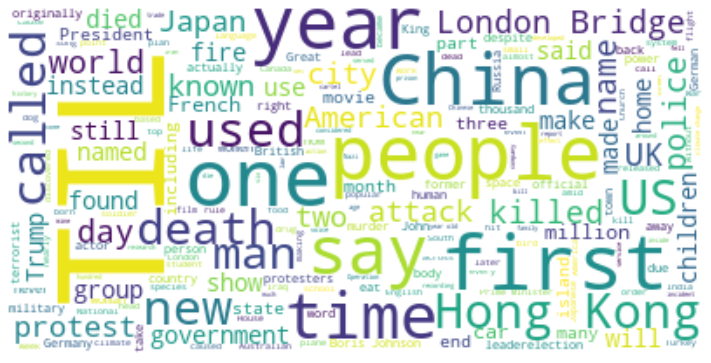

In [759]:
cloud = WordCloud(background_color='white', max_words=200,
                  stopwords=None)
cloud.generate(sent_str3)
fig, ax = plt.subplots(figsize=(12.5, 7.5))
ax.imshow(cloud, interpolation='bilinear')
ax.axis('off')
plt.show()
plt.close() 

Wordcloud with 'til' term

In [746]:
# Converting the list of strings into a single long string 
sent_str = ""
for i in clean_posts:
    sent_str += str(i) + " "
sent_str = sent_str[:-1]
#print (sent_str)

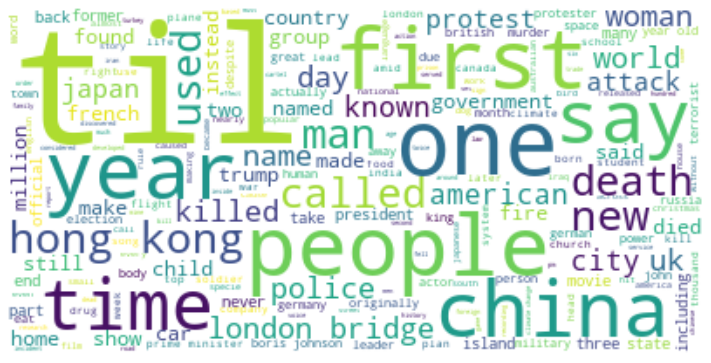

In [752]:
#word cloud with 'til' term
full_text = sent_str
cloud = WordCloud(background_color='white', max_words=200,
                  stopwords=None)
cloud.generate(full_text)
fig, ax = plt.subplots(figsize=(12.5, 7.5))
ax.imshow(cloud, interpolation='bilinear')
ax.axis('off')
plt.show()
plt.close() 

wordcloud after removing 'til' term

In [753]:
# Converting the list of strings into a single long string 
sent_str2 = ""
for i in clean_posts2:
    sent_str2 += str(i) + " "
sent_str2 = sent_str2[:-1]

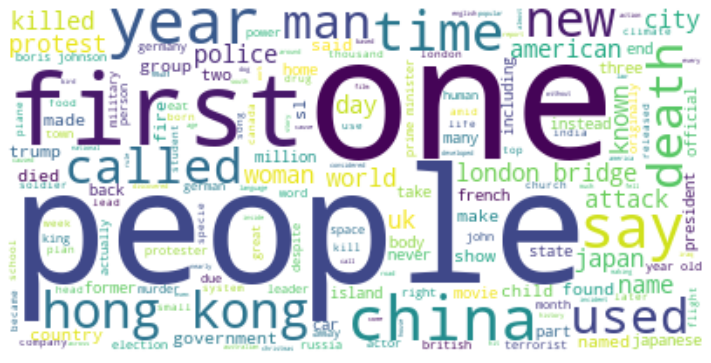

In [754]:
cloud = WordCloud(background_color='white', max_words=200,
                  stopwords=None)
cloud.generate(sent_str2)
fig, ax = plt.subplots(figsize=(12.5, 7.5))
ax.imshow(cloud, interpolation='bilinear')
ax.axis('off')
plt.show()
plt.close() 

Re-merging the clean posts back into the dataframe

In [248]:
all_df['clean_posts'] = clean_posts

Creating a new column that removes 'til' from the TIL subreddit posts 
- creating a separate column as i want to compare the difference in model scores when fitting against posts with 'til' VS posts without the 'til' term

In [356]:
clean_posts2 = pd.Series(clean_posts)
clean_posts2 = clean_posts2.str.replace('til','')

In [357]:
all_df['clean_posts2'] = clean_posts2

In [358]:
all_df.tail(1)

,subreddit,title,clean_posts,clean_posts2
1691,0,"TIL that for 200 years, the wrong portrait was...",til year wrong portrait used french mathematic...,year wrong portrait used french mathematician...


Reminder:
- 'title' contains original posts 
- 'clean_posts' contains cleaned posts 
- 'clean_posts2' contains cleaned posts without 'til'

In [346]:
#Note to self: this method works too, if we want to replace a term via the dataframe directly 
#posts_no_til = all_df['clean_posts'].str.replace('til','')

**Note to self:**
- The python .replace method only applies to strings so we have to .str when applying it to either a series or a dataframe; this does not work on a list 

# Model Fitting

**1. Naive Bayes Model for 'baseline' scoring with clean_posts as target var** 

Train-Test-Split Data after pre-processing 

In [251]:
# Import train_test_split.
from sklearn.model_selection import train_test_split

X = all_df['clean_posts']
y = all_df['subreddit']

# Create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(X, #this is the X (predictor vars)
                                                    y, #this is the y (target var)
                                                    stratify=y, #preserves the ratio of X:y in train and test sets
                                                    test_size = 0.25,
                                                    random_state = 42)

Importing all 3 naive bayes model to test out which one works better. Since the model adopted depends on the nature of the predictor variables, in this case:
- we could use BernoulliNB or MultinomialNB when using countvectorizer (since each term will have an integer count) though it also seems that most terms could only have 1 count each, hence making it more like a dummy var (this is where BernoulliNB could work better)

- we could use GaussianNB if we apply the TFIDvectorizer as TFID returns a float value which is continuous

In [300]:
# Import our model!
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB

# Instantiate our model!
nb = BernoulliNB()
mb = MultinomialNB()
gb = GaussianNB()


Am aware that we could use pipeline here but i'm going to perform the operations manually first and use pipe when building up our other models

In [302]:
# Instantiate our Vectorizers.
cvec = CountVectorizer(stop_words = 'english')
tvec = TfidfVectorizer(stop_words = 'english')
#could add in max_features = x later 

# Fit our Count/TFID Vectorizer on the training data and transform training data.
X_train_cvec = cvec.fit_transform(X_train)
X_train_tvec = tvec.fit_transform(X_train)


X_train_cvec_df = pd.DataFrame(X_train_cvec.toarray(), 
                               columns = cvec.get_feature_names())

X_train_tvec_df = pd.DataFrame(X_train_tvec.toarray(), 
                               columns = tvec.get_feature_names())


In [305]:
X_train_cvec #note this is the output of the cvec transformation hence we need to .toarray() it

<1269x5584 sparse matrix of type '<class 'numpy.int64'>'
	with 16965 stored elements in Compressed Sparse Row format>

In [307]:
X_train_cvec.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [303]:
X_train_cvec_df.head()

,abandon,abandoned,abc,abdul,abe,ability,abject,able,abnormality,abolished,...,yu,zambia,ze,zealand,zeppelin,zero,zi,zone,zoo,zwigoff
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Taking a look at the top 10 word features in the combined dataframe**

In [705]:
top_10_cvec = X_train_cvec_df.sum().sort_values(ascending=False).head(10)
top_10_cvec = pd.DataFrame(top_10_cvec).T
top_10_cvec

,til,year,people,london,death,china,say,world,used,time
0,743,97,66,60,58,56,55,51,49,48


In [703]:
top_10_tvec = X_train_tvec_df.sum().sort_values(ascending=False).head(10)
top_10_tvec = pd.DataFrame(top_10_tvec).T
top_10_tvec

,til,london,year,china,say,bridge,police,kong,hong,people
0,45.962389,14.150287,13.569741,12.457804,11.93338,11.913407,11.342905,11.216814,11.216814,11.006309


In [304]:
X_train_tvec_df.head()

,abandon,abandoned,abc,abdul,abe,ability,abject,able,abnormality,abolished,...,yu,zambia,ze,zealand,zeppelin,zero,zi,zone,zoo,zwigoff
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.328609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [312]:
print(X_train_cvec_df.shape)
print(X_train_tvec_df.shape)

(1269, 5584)
(1269, 5584)


We have 5584 text features, many of which appear to be empty - looks like we have a rather sparse matrix. let's see how this affects the model score

In [308]:
cvec.transform(X_test).todense() 
#note that this is similar to what we did above when we applied .toarray()
#however .todense() converts it into a matrix type instead of an array type. A matrix is a sub-class of an array
#matrices go up to 2D but arrays go up to N-dimensions

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [309]:
# Transform our testing data with the already-fit Count / TFID Vectorizer.
X_test_cvec = cvec.transform(X_test).todense() 
X_test_tvec = tvec.transform(X_test).todense()  

X_test_cvec_df = pd.DataFrame(X_test_cvec, 
                              columns = cvec.get_feature_names())

X_test_tvec_df = pd.DataFrame(X_test_tvec, 
                              columns = tvec.get_feature_names())

In [313]:
print(X_test_cvec_df.shape)
print(X_test_tvec_df.shape)

(423, 5584)
(423, 5584)


**Fit to Naive Bayes Models**

In [315]:
# Fit our models
model_nb = nb.fit(X_train_cvec, y_train)  #fitting Bernoulli on CVEC 
model_mb = mb.fit(X_train_cvec, y_train)  #fitting Multinomial on CVEC
model_gb = gb.fit(X_train_tvec.toarray(), y_train)  #fitting Gaussian on TVEC

In [320]:
# Generate our predictions!
pred_nb = model_nb.predict(X_test_cvec)
pred_mb = model_mb.predict(X_test_cvec)
pred_gb = model_gb.predict(X_test_tvec)

Train Set Scores

In [323]:
# Score our model on the training set.
print("Cvec train score (Bernoulli):", model_nb.score(X_train_cvec, y_train))
print("Cvec train score(Multinomial):", model_mb.score(X_train_cvec, y_train))
print("Tvec train score(Gaussian):", model_gb.score(X_train_tvec.toarray(), y_train))

Cvec train score (Bernoulli): 1.0
Cvec train score(Multinomial): 0.9992119779353822
Tvec train score(Gaussian): 1.0


Test Set Scores 

In [325]:
# Score our model on the testing set.
print("Cvec test score (Bernoulli):", model_nb.score(X_test_cvec, y_test))
print("Cvec test score(Multinomial):", model_mb.score(X_test_cvec, y_test))
print("Tvec test score(Gaussian):", model_gb.score(X_test_tvec, y_test))

Cvec test score (Bernoulli): 0.9952718676122931
Cvec test score(Multinomial): 0.9574468085106383
Tvec test score(Gaussian): 0.8983451536643026


**Interpreting the results**

These are the 'base of baseline' scores - basically fitted against either CVEC or TVEC (default options - meaning no cap on max features selected) 

Both the training and test scores are on the high side, indicating overfitting. This is especially clear when comparing the TVEC training and test scores - huge differential btw the 2. 

Potential remedies:
- remove 'tif' term which is present in all the TIF posts
- reduce max_features to a lower number 


**Modification 1: Repeating the process but without the 'til' term**

In [360]:
all_df['clean_posts'].tail(2)

1690    til several order monk nun developed sign lang...
1691    til year wrong portrait used french mathematic...
Name: clean_posts, dtype: object

In [361]:
all_df['clean_posts2'].tail(2)

1690     several order monk nun developed sign languag...
1691     year wrong portrait used french mathematician...
Name: clean_posts2, dtype: object

Notice how the top 10 terms change after removing 'til' 

In [727]:
top_10_cvec

,til,year,people,london,death,china,say,world,used,time
0,743,97,66,60,58,56,55,51,49,48


In [711]:
top_10_tvec

,til,london,year,china,say,bridge,police,kong,hong,people
0,45.962389,14.150287,13.569741,12.457804,11.93338,11.913407,11.342905,11.216814,11.216814,11.006309


In [707]:
top_10_cvec2 = X2_train_cvec_df.sum().sort_values(ascending=False).head(10)
top_10_cvec2 = pd.DataFrame(top_10_cvec2).T
top_10_cvec2

,year,people,london,death,china,say,world,used,time,hong
0,97,66,60,58,56,55,51,49,48,47


In [709]:
top_10_tvec2 = X2_train_tvec_df.sum().sort_values(ascending=False).head(10)
top_10_tvec2 = pd.DataFrame(top_10_tvec2).T
top_10_tvec2

,london,year,china,say,bridge,police,hong,kong,people,attack
0,14.151997,13.574399,12.455821,11.934882,11.91403,11.347278,11.216814,11.216814,11.01557,10.826013


In [362]:
# Import train_test_split.
from sklearn.model_selection import train_test_split

X2 = all_df['clean_posts2']
y2 = all_df['subreddit']

# Create train_test_split.
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, #this is the X (predictor vars)
                                                    y2, #this is the y (target var)
                                                    stratify=y, #preserves the ratio of X:y in train and test sets
                                                    test_size = 0.25,
                                                    random_state = 42)


# Vectorizers already instantiated above.

# Fit our CountVectorizer on the training data and transform training data.
X2_train_cvec = cvec.fit_transform(X2_train)
X2_train_tvec = tvec.fit_transform(X2_train)


X2_train_cvec_df = pd.DataFrame(X2_train_cvec.toarray(), 
                               columns = cvec.get_feature_names())

X2_train_tvec_df = pd.DataFrame(X2_train_tvec.toarray(), 
                               columns = tvec.get_feature_names())


# Fit our Count/TFID Vectorizer on the test data and transform test data.

X2_test_cvec = cvec.transform(X2_test).todense() 
X2_test_tvec = tvec.transform(X2_test).todense()  

X2_test_cvec_df = pd.DataFrame(X2_test_cvec, 
                              columns = cvec.get_feature_names())

X2_test_tvec_df = pd.DataFrame(X2_test_tvec, 
                              columns = tvec.get_feature_names())


# Fit to various Naive Bayes models
model_nb2 = nb.fit(X2_train_cvec, y2_train)  #fitting Bernoulli on CVEC 
model_mb2 = mb.fit(X2_train_cvec, y2_train)  #fitting Multinomial on CVEC
model_gb2 = gb.fit(X2_train_tvec.toarray(), y2_train)  #fitting Gaussian on TVEC

print("Scores without 'til' term")
# Score our model on the training set.
print("Cvec train score (Bernoulli):", model_nb2.score(X2_train_cvec, y2_train))
print("Cvec train score(Multinomial):", model_mb2.score(X2_train_cvec, y2_train))
print("Tvec train score(Gaussian):", model_gb2.score(X2_train_tvec.toarray(), y2_train))

print()

# Score our model on the testing set.
print("Cvec test score (Bernoulli):", model_nb2.score(X2_test_cvec, y2_test))
print("Cvec test score(Multinomial):", model_mb2.score(X2_test_cvec, y2_test))
print("Tvec test score(Gaussian):", model_gb2.score(X2_test_tvec, y2_test))

Scores without 'til' term
Cvec train score (Bernoulli): 0.9889676910953507
Cvec train score(Multinomial): 0.9936958234830575
Tvec train score(Gaussian): 1.0

Cvec test score (Bernoulli): 0.9267139479905437
Cvec test score(Multinomial): 0.9196217494089834
Tvec test score(Gaussian): 0.8912529550827423


Model score comparisons w and w/o 'til term' but without capping max features: 

- The scores for the models fitted against dataset w/o 'til' term are all slightly less than those with the 'til' term -- expectedly so -- indicating a positive improvement as it appears to be less overfitted

**Modifications 2: Generating more results with different combinations of Naive Bayes**

- Imported a customised class with functions to take in a dictionary of models and thier respective parameters to be used 

- These models/parameters will be passed through Gridsearch 

- The final output is a table summarizing the different model scores

- I will be tuning: max/min features and n-grams for the vectorizers

Customised Class 

In [409]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV

class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

**Running the same Baeysian models above (except Gaussian), but with hyper-parameter tuning**

Also Gaussian can't run because we need to .array( ) the TFIDVector output before scoring it in GaussianNB( ) but i'm not sure how to do that in pipe (if not it will run an error mentioning that you have passed it a sparse matrix) 

models2 = {
    'TVEC + Gaussian': Pipeline([("tvec",TfidfVectorizer()),("gb",GaussianNB())]),
}

params2 = {
    'TVEC + Gaussian': {'vec__max_features': [250, 500, 750],
                         'vec__min_df': [2, 3],  #at least 2 or 3 features 
                         'vec__max_df': [.9, .95],  #go up to 90 or 95%
                         'vec__ngram_range': [(1,1), (1,2)] #only unigram, or unigram as well as bigram
                            }
}

helper2 = EstimatorSelectionHelper(models2, params2)

helper2.fit(X2_train, y2_train, n_jobs= -1)

In [564]:
#Generating the 2 dictionary inputs as arguments for the class function above
#note to self: be careful when keying in the params; name__features needs to be two underscores __ not one _ 

models1 = {
    'TVEC + Bernoulli': Pipeline([("vec",TfidfVectorizer()),("nb",BernoulliNB())]),
    'TVEC + Multinomial': Pipeline([("vec",TfidfVectorizer()),("mb",MultinomialNB())]),
    'CVEC + Bernoulli': Pipeline([("vec",CountVectorizer()),("nb",BernoulliNB())]),
    'CVEC + Multinomial': Pipeline([("vec",CountVectorizer()),("mb",MultinomialNB())])
    
   # 'TVEC + Gaussian': Pipeline([("tvec",TfidfVectorizer()),("gb",GaussianNB())]),
}

params1 = {
    'TVEC + Bernoulli': {'vec__max_features': [250, 500, 750],
                         'vec__min_df': [2, 3],  #at least 2 or 3 features 
                         'vec__max_df': [.9, .95],  #go up to 90 or 95%
                         'vec__ngram_range': [(1,1), (1,2)] #only unigram, or unigram as well as bigram
                            },
    'TVEC + Multinomial': {'vec__max_features': [250, 500, 750],
                            'vec__min_df': [2, 3],  #at least 2 or 3 features 
                            'vec__max_df': [.9, .95],  #go up to 90 or 95%
                            'vec__ngram_range': [(1,1), (1,2)] #only unigram, or unigram as well as bigram
                            },
    'CVEC + Bernoulli': {'vec__max_features': [250, 500, 750],
                             'vec__min_df': [2, 3],  #at least 2 or 3 features 
                             'vec__max_df': [.9, .95],  #go up to 90 or 95%
                             'vec__ngram_range': [(1,1), (1,2)] #only unigram, or unigram as well as bigram
                        },
    'CVEC + Multinomial': {'vec__max_features': [250, 500, 750],
                             'vec__min_df': [2, 3],  #at least 2 or 3 features 
                             'vec__max_df': [.9, .95],  #go up to 90 or 95%
                             'vec__ngram_range': [(1,1), (1,2)] #only unigram, or unigram as well as bigram
                            }
  #  'TVEC + Gaussian': {'tvec__max_features': [250, 500, 750],
   #                          'tvec__min_df': [2, 3],  #at least 2 or 3 features 
       #                      'tvec__max_df': [.9, .95],  #go up to 90 or 95%
   #                          'tvec__ngram_range': [(1,1), (1,2)] #only unigram, or unigram as well as bigram
   #                         }
}

**Fitting the data on the train sets without the 'til' term**

In [506]:
helper1 = EstimatorSelectionHelper(models1, params1)

helper1.fit(X2_train, y2_train, n_jobs= -1)

Running GridSearchCV for TVEC + Bernoulli.
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Running GridSearchCV for TVEC + Multinomial.
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Running GridSearchCV for CVEC + Bernoulli.
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Running GridSearchCV for CVEC + Multinomial.
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    1.8s finished


24 candidates because: 3 * 2 * 2 * 2 possible combinations of models * 3 k-folds = 72 fits

- There will be 96 scores here from: 4 models * 24 possible combinations for each model 

Interpreting the table:

- For each model combination, there will be 3 k-fold scores. The table is displaying the min, max and mean score from these 3 values

- TVEC + multinomial combination comes in top 4 with parameters choosing top end of the max feature range

In [507]:
helper1.score_summary(sort_by='mean_score').head()

TVEC + Bernoulli
TVEC + Multinomial
CVEC + Bernoulli
CVEC + Multinomial


,estimator,min_score,mean_score,max_score,std_score,vec__max_df,vec__max_features,vec__min_df,vec__ngram_range
34,TVEC + Multinomial,0.888626,0.897553,0.910165,0.00917157,0.9,750,3,"(1, 1)"
46,TVEC + Multinomial,0.888626,0.897553,0.910165,0.00917157,0.95,750,3,"(1, 1)"
32,TVEC + Multinomial,0.884434,0.895984,0.914894,0.0134799,0.9,750,2,"(1, 1)"
44,TVEC + Multinomial,0.884434,0.895984,0.914894,0.0134799,0.95,750,2,"(1, 1)"
10,TVEC + Bernoulli,0.860849,0.88971,0.905437,0.0204352,0.9,750,3,"(1, 1)"


Interpretation of results:

- The hyper-parameter tuning seems to have really helped with the over-fitting problem that was apparent in the untuned Baeysian models. 


- The top scoring model combinations (from training to test values) have shifted here from TVEC + Multinomial to TVEC + Bernoulli indicating that TVEC + Multinomial might have been slightly overfitted? even though 2/4 of the top 4 scores are still from TVEC + Multinomial


- The model with the best score is **TVEC with Multinomial**, and the highest feature selection from my parameters and only unigrams, which is not the most intuitive as i would imagine that either a bigram or mix of uni and bigram combination (as this would better capture the context of each post) would yield better results


Note to self:
- figure out how to extract the best grid search model and score it against the test set


Note to self:


- could add confusion matrix (specifically the specificity score) - could mention that if the application is to identify potentially harmful reddit threads, then false negatives would be more costly than false positives so we want to optimize for false negatives 

- stretch goal is to automate the entire confusion matrix metric generation into the custom class function

- consider changing the params of the grid search 


**Further refining the model by testing for confusion matrix metrics**

Trying to make slight modifications to the class function defined above 

If you change the scoring metric ("scoring" argument under the fit function) below to "precision" or "recall" etc you can choose to optimize for different metrics

Question: why can't i pass scoring as an open argument in the .fit( ) function below?

In [526]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV

class EstimatorSelectionHelper2:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring='accuracy', refit=False): #this is where we change scoring
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

**Generating top 5 models that optimize for the different confusion matrix metrics**

In [527]:
helper2 = EstimatorSelectionHelper2(models1, params1)

helper2.fit(X2_train, y2_train, n_jobs= -1)

Running GridSearchCV for TVEC + Bernoulli.
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed:    6.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Running GridSearchCV for TVEC + Multinomial.
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Running GridSearchCV for CVEC + Bernoulli.
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Running GridSearchCV for CVEC + Multinomial.
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    2.0s finished


Top Accuracy Scorers

In [528]:
#this is the default score that the function optimises for so just checking the results.. it squares off so that's good
acc_optimise = helper2.score_summary(sort_by='mean_score').head()
acc_optimise

TVEC + Bernoulli
TVEC + Multinomial
CVEC + Bernoulli
CVEC + Multinomial


,estimator,min_score,mean_score,max_score,std_score,vec__max_df,vec__max_features,vec__min_df,vec__ngram_range
34,TVEC + Multinomial,0.888626,0.897553,0.910165,0.00917157,0.9,750,3,"(1, 1)"
46,TVEC + Multinomial,0.888626,0.897553,0.910165,0.00917157,0.95,750,3,"(1, 1)"
32,TVEC + Multinomial,0.884434,0.895984,0.914894,0.0134799,0.9,750,2,"(1, 1)"
44,TVEC + Multinomial,0.884434,0.895984,0.914894,0.0134799,0.95,750,2,"(1, 1)"
10,TVEC + Bernoulli,0.860849,0.88971,0.905437,0.0204352,0.9,750,3,"(1, 1)"


Top Balanced Accuracy Scorers
- The balanced_accuracy_score function computes the balanced accuracy, which avoids inflated performance estimates on imbalanced datasets.

- In the binary case, balanced accuracy is equal to the arithmetic mean of sensitivity (true positive rate) and specificity (true negative rate), or the area under the ROC curve with binary predictions rather than scores.

- If the classifier performs equally well on either class, this term reduces to the conventional accuracy (i.e., the number of correct predictions divided by the total number of predictions).

In [520]:
bal_acc_optimise = helper2.score_summary(sort_by='mean_score').head()
bal_acc_optimise

TVEC + Bernoulli
TVEC + Multinomial
CVEC + Bernoulli
CVEC + Multinomial


,estimator,min_score,mean_score,max_score,std_score,vec__max_df,vec__max_features,vec__min_df,vec__ngram_range
58,CVEC + Bernoulli,0.863655,0.889228,0.906647,0.0184742,0.9,750,3,"(1, 1)"
22,TVEC + Bernoulli,0.863655,0.889228,0.906647,0.0184742,0.95,750,3,"(1, 1)"
70,CVEC + Bernoulli,0.863655,0.889228,0.906647,0.0184742,0.95,750,3,"(1, 1)"
10,TVEC + Bernoulli,0.863655,0.889228,0.906647,0.0184742,0.9,750,3,"(1, 1)"
34,TVEC + Multinomial,0.877394,0.88793,0.900855,0.00972604,0.9,750,3,"(1, 1)"


Top F1 Scorers
- f1 score finds the optimal blend between precision and sensitivity / recall 

In [515]:
f1_optimise = helper2.score_summary(sort_by='mean_score').head()
f1_optimise

TVEC + Bernoulli
TVEC + Multinomial
CVEC + Bernoulli
CVEC + Multinomial


,estimator,min_score,mean_score,max_score,std_score,vec__max_df,vec__max_features,vec__min_df,vec__ngram_range
34,TVEC + Multinomial,0.857143,0.869718,0.885542,0.0118194,0.9,750,3,"(1, 1)"
46,TVEC + Multinomial,0.857143,0.869718,0.885542,0.0118194,0.95,750,3,"(1, 1)"
58,CVEC + Bernoulli,0.838356,0.868587,0.88764,0.0216171,0.9,750,3,"(1, 1)"
22,TVEC + Bernoulli,0.838356,0.868587,0.88764,0.0216171,0.95,750,3,"(1, 1)"
70,CVEC + Bernoulli,0.838356,0.868587,0.88764,0.0216171,0.95,750,3,"(1, 1)"


Top Specificity Scorers

In [510]:
#specificity 
#spec_optimise = helper2.score_summary(sort_by='mean_score').head()
spec_optimise

TVEC + Bernoulli
TVEC + Multinomial
CVEC + Bernoulli
CVEC + Multinomial


,estimator,min_score,mean_score,max_score,std_score,vec__max_df,vec__max_features,vec__min_df,vec__ngram_range
46,TVEC + Multinomial,0.895706,0.908027,0.924528,0.0121325,0.95,750,3,"(1, 1)"
34,TVEC + Multinomial,0.895706,0.908027,0.924528,0.0121325,0.9,750,3,"(1, 1)"
35,TVEC + Multinomial,0.86747,0.905282,0.947712,0.0329213,0.9,750,3,"(1, 2)"
47,TVEC + Multinomial,0.86747,0.905282,0.947712,0.0329213,0.95,750,3,"(1, 2)"
33,TVEC + Multinomial,0.878049,0.903073,0.922078,0.0184717,0.9,750,2,"(1, 2)"


**Summary of results for models w top confusion metrics**

Top Model that optimises for:

1) Specificity (true -ives): TVEC + Multinomial 


2) F1-score (balance btw sens and prec): TVEC + Multinomial


3) Balanced Accuracy: CVEC + Bernoulli



**Testing out another function that helps to optimize for confusion matrix scores too**

Difference being:

1) You can pass the metric that you want to measure directly as an argument


2) The function produces a confusion matrix 


3) It fits on training set and predicts based on the test set (unlike above that fits and predicts based on training set alone) i think


4) However you have to specify the model that you are going to be optimizing it on 


Since we have determined that the TVEC + Multinomial combination seems to be the winner, we have chosen that model to run these further tests on


Credit: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

In [521]:
#find out what make_scorer function does 
#Generating the 2 dictionary inputs as arguments for the class function above
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

TB = Pipeline([("tvec",TfidfVectorizer()),("mb",MultinomialNB())])

params = {
            'tvec__max_features': [250, 500, 750],
            'tvec__min_df': [2, 3],  #at least 2 or 3 features 
            'tvec__max_df': [.9, .95],  #go up to 90 or 95%
            'tvec__ngram_range': [(1,1), (1,2)] #only unigram, or unigram as well as bigram
        }


scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)

}

In [522]:
def grid_search_wrapper(X_train, y_train, X_test, y_test, refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=5)
    grid_search = GridSearchCV(TB, params, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of TVEC + Multinomial NB optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [523]:
grid_search_wrapper(X2_train, y2_train, X2_test, y2_test, refit_score='recall_score');

Best params for recall_score
{'tvec__max_df': 0.9, 'tvec__max_features': 750, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}

Confusion matrix of TVEC + Bernoulli NB optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       237        13
pos        36       137


In [524]:
grid_search_TB = grid_search_wrapper(X2_train, y2_train, X2_test, y2_test, refit_score='precision_score')

Best params for precision_score
{'tvec__max_df': 0.9, 'tvec__max_features': 750, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2)}

Confusion matrix of TVEC + Bernoulli NB optimized for precision_score on the test data:
     pred_neg  pred_pos
neg       239        11
pos        37       136


In [525]:
grid_search_TB = grid_search_wrapper(X2_train, y2_train, X2_test, y2_test, refit_score='f1_score')

Best params for f1_score
{'tvec__max_df': 0.9, 'tvec__max_features': 750, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 1)}

Confusion matrix of TVEC + Bernoulli NB optimized for f1_score on the test data:
     pred_neg  pred_pos
neg       237        13
pos        35       138


Since i found out that the other models were optimised by increasing max features, i am going to test it out by increasing max features to 1700 on the Bayes Model as well. 

In [574]:
models2 = {
    'TVEC + Multinomial': Pipeline([("vec",TfidfVectorizer()),("mb",MultinomialNB())])
}

params2 = {
    'TVEC + Multinomial': {'vec__max_features': [250, 500, 1700],
                            'vec__min_df': [2, 3],  #at least 2 or 3 features 
                            'vec__max_df': [.9, .95],  #go up to 90 or 95%
                            'vec__ngram_range': [(1,1), (1,2)] #only unigram, or unigram as well as bigram
                            }
}

In [575]:
helper2 = EstimatorSelectionHelper(models2, params2)
helper2.fit(X2_train, y2_train, n_jobs= -1)

Running GridSearchCV for TVEC + Multinomial.
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    1.9s finished


In [576]:
helper2.score_summary().head(3)

TVEC + Multinomial


,estimator,min_score,mean_score,max_score,std_score,vec__max_df,vec__max_features,vec__min_df,vec__ngram_range
8,TVEC + Multinomial,0.896226,0.908597,0.92435,0.0117279,0.9,1700,2,"(1, 1)"
20,TVEC + Multinomial,0.896226,0.908597,0.92435,0.0117279,0.95,1700,2,"(1, 1)"
9,TVEC + Multinomial,0.898585,0.908591,0.926714,0.0128381,0.9,1700,2,"(1, 2)"


Scores improved marginally from .897 to .908 

# 2. Other Model fittings for comparison against Naive Bayes

**Creating Pipeline 1**

Our first pipeline will consist of two stages:
1. An instance of `CountVectorizer` (can consider TFID)
2. A `LogisticRegression` instance

In [258]:
#loading libraries for model fitting 
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression

In [644]:
pipe1 = Pipeline([
    ("cvec",CountVectorizer()),
    ("lr",LogisticRegression())
])

In [645]:
pipe1.steps

[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                  lowercase=True, max_df=1.0, max_features=None, min_df=1,
                  ngram_range=(1, 1), preprocessor=None, stop_words=None,
                  strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=None, vocabulary=None)),
 ('lr',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='warn', tol=0.0001, verbose=0,
                     warm_start=False))]

**Calculating our base pipeline 1 score**

Using training set without 'til' term in the TIL subreddit posts

K-fold cross val score

In [646]:
print(cross_val_score(pipe1, X2_train, y2_train, cv=5))
print(cross_val_score(pipe1, X2_train, y2_train, cv=5).mean()) 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

[0.91338583 0.89370079 0.94094488 0.92125984 0.93675889]
0.9212100463726619


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [643]:
pipe1.fit(X2_train, y2_train) #fitting on the training set
print("Train score:", pipe1.score(X2_train, y2_train)) #scoring on both the train
print("Test score:", pipe1.score(X2_test, y2_test)) #and the test sets 

Train score: 1.0
Test score: 0.9196217494089834


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**Using Gridsearch to optimize our parameters**

In [655]:
#defining the various parameters that we want the gridsearch to test on to determine the optimal parameter combination
pipe_params = {
    'lr__penalty': ['l1', 'l2'], #clarify why elasticnet and none option cannot be used in a 'liblinear model?' must use 'saga solver?' 
    'cvec__max_features': [500, 750, 1700],
    'cvec__min_df': [2, 3],  #appears in at least 2 or 3 documents 
    'cvec__max_df': [.9, .95],  #appears in up to 90 or 95% of documents
    'cvec__ngram_range': [(1,1), (1,2)] #only unigram, or unigram as well as bigram
   }
 
gs = GridSearchCV(pipe1, param_grid=pipe_params, cv=5, n_jobs=-1) 
#rmb n_jobs selects for the num of cores on your comp you want to utilize to run your computation 

gs.fit(X2_train, y2_train)

print("Grid search best train score:",gs.best_score_)
print("Grid search best test score:",gs.score(X2_test, y2_test))

gs.best_params_
#print(gs.best_estimator_.score(X_train, y_train))
#print(gs.best_estimator_.score(X_test, y_test))

Grid search best train score: 0.9156816390858944
Grid search best test score: 0.8888888888888888


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'cvec__max_df': 0.9,
 'cvec__max_features': 1700,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'lr__penalty': 'l2'}

I played around with max features and realised that the scores are optimized at >= 1700 features - anything beyond that does not improve the test scores 

Defined a function that prints out a summary of your confusion matrix scores 

In [602]:
# Import confusion matrix.
from sklearn.metrics import confusion_matrix

def cm_sum (model, X_test, y_test):
    # Generate predictions.
    preds = model.predict(X_test)
    
    #Save TN/FP/FN/TP values.
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    # Sensitivity is the true +ive rate 
    sens = tp/(fn+tp)
    print(f'Sensitivity: {round(sens,4)}')
    
    #Specificity is the true -ive rate
    spec = tn/(tn+fp)
    print(f'Specificity: {round(spec,4)}')
    
    #precision of our test set 
    prec = tp/(tp+fp)
    print(f'Precision: {round(prec,4)}')
    
    #Accuracy
    acc = (tp+tn)/(tp+tn+fp+fn)
    print(f'Accuracy: {round(acc,4)}')

    #F1 score 
    f1 = 2 * ((prec*sens)/(prec+sens))
    print(f'F1 Score: {round(f1,4)}')

#The F1 score is the harmonic mean of precision and recall and helps to find the optimal blend of precision and sens
#We use the harmonic mean instead of a simple average because it punishes extreme values. A classifier with a 
#precision of 1.0 and a recall of 0.0 has a simple average of 0.5 but an F1 score of 0. The F1 score gives equal 
#weight to both measures and is a specific example of the general Fβ metric where β can be adjusted to give more 
#weight to either recall or precision

In [603]:
#confusion matrix summary for pipe 1
cm_sum(gs, X2_test, y2_test)

Sensitivity: 0.8382
Specificity: 0.948
Precision: 0.9177
Accuracy: 0.9031
F1 Score: 0.8761


**Pipeline 2 using TFID Vectorizer instead of Count Vectorizer**

In [669]:
pipe2 = Pipeline([
    ("tvec", TfidfVectorizer()), #term-frequency, inverse document frequency vectorizer
    ("lr",LogisticRegression())
])

In [670]:
pipe2.steps

[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.float64'>, encoding='utf-8',
                  input='content', lowercase=True, max_df=1.0, max_features=None,
                  min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                  smooth_idf=True, stop_words=None, strip_accents=None,
                  sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=None, use_idf=True, vocabulary=None)),
 ('lr',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='warn', tol=0.0001, verbose=0,
                     warm_start=False))]

In [671]:
print(cross_val_score(pipe2, X2_train, y2_train, cv=5))
print(cross_val_score(pipe2, X2_train, y2_train, cv=5).mean())

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

[0.90551181 0.86614173 0.90944882 0.87007874 0.87747036]
0.885730291618686


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [672]:
pipe2.fit(X2_train, y2_train) #fitting on the training set

print("Train score:", pipe2.score(X2_train, y2_train)) #scoring on both the train
print("Test score:", pipe2.score(X2_test, y2_test)) #and the test sets 


Train score: 0.9605988967691096
Test score: 0.8652482269503546


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Using Gridsearch on TFID Vectorizer

In [654]:
#defining the various parameters that we want the gridsearch to test on to determine the optimal parameter combination
pipe_params = {
    'lr__penalty': ['l1', 'l2'],
    'tvec__max_features': [500, 750, 1700],
    'tvec__min_df': [2, 3],  #at least 2 or 3 features 
    'tvec__max_df': [.9, .95],  #go up to 90 or 95%
    'tvec__ngram_range': [(1,1), (1,2)] #only unigram, or unigram as well as bigram
}

gs = GridSearchCV(pipe2, param_grid=pipe_params, cv=5, n_jobs=-1) 
#rmb n_jobs selects for the num of cores on your comp you want to utilize to run your computation 

gs.fit(X2_train, y2_train)

print("Grid search best train score:",gs.best_score_)
print("Grid search best test score:",gs.score(X2_test, y2_test))

gs.best_params_
#print(gs.best_estimator_.score(X_train, y_train))
#print(gs.best_estimator_.score(X_test, y_test))

Grid search best train score: 0.8991331757289204
Grid search best test score: 0.8676122931442081


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'lr__penalty': 'l2',
 'tvec__max_df': 0.9,
 'tvec__max_features': 1700,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 1)}

The model scores are slightly better using Count vectorizer than TFIDF vect. 

In [588]:
pipe2_cm = cm_sum(gs, X2_test, y2_test)
pipe2_cm

Sensitivity: 0.815
Specificity: 0.976
Precision: 0.9592
Accuracy: 0.9102
F1 Score: 0.8812


Looks like TFIDF, log reg is achieving better overall scores (in all but sensitivity) 

**Fitting the model on a Decision Tree**

In [607]:
from sklearn.tree import DecisionTreeClassifier

pipe3 = Pipeline([
    ("tvec",TfidfVectorizer()),
    ("dt",DecisionTreeClassifier())
])

pipe3.steps

[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.float64'>, encoding='utf-8',
                  input='content', lowercase=True, max_df=1.0, max_features=None,
                  min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                  smooth_idf=True, stop_words=None, strip_accents=None,
                  sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=None, use_idf=True, vocabulary=None)),
 ('dt',
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                         max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, presort=False,
                         random_state=None, splitter='best'))]

In [613]:
# Fit model.
pipe3.fit(X2_train, y2_train);
#note the hyper-parameters that we can further tune 
#max_depth will determine the height of your tree
#max_features 
#criterion - there are criterions other than gini

In [611]:
# Evaluate model.
print("Score on training set:", pipe3.score(X2_train,y2_train))
print("Score on test set:", pipe3.score(X2_test,y2_test))

Score on training set: 1.0
Score on test set: 0.817966903073286


In [624]:
#defining the various parameters that we want the gridsearch to test on to determine the optimal parameter combination
#Note to self: Parameters of pipelines can be set using ‘__’ separated parameter names:

pipe_params = {
    'tvec__max_features': [500, 750, 1700],
    'tvec__min_df': [2, 3],  #at least 2 or 3 features 
    'tvec__max_df': [.9, .95],  #go up to 90 or 95%
    'tvec__ngram_range': [(1,1), (1,2)], #only unigram, or unigram as well as bigram
               'dt__max_depth': [10, 20 ,30],
               'dt__min_samples_split': [25,30,35],
               'dt__min_samples_leaf':[1,20,25]
}

gs = GridSearchCV(pipe3, param_grid=pipe_params, cv=5, n_jobs=-1) 
#rmb n_jobs selects for the num of cores on your comp you want to utilize to run your computation 

gs.fit(X2_train, y2_train)

print("Grid search best train score:",gs.best_score_)
print("Grid search best test score:",gs.score(X2_test, y2_test))

gs.best_params_
#print(gs.best_estimator_.score(X_train, y_train))
#print(gs.best_estimator_.score(X_test, y_test))

Grid search best train score: 0.8486997635933806
Grid search best test score: 0.8037825059101655


{'dt__max_depth': 30,
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 25,
 'tvec__max_df': 0.9,
 'tvec__max_features': 1700,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 1)}